In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, roc_auc_score, f1_score, mean_absolute_error, classification_report 
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

Análise Exploratória dos Dados

In [79]:
data_location = "../Projeto-Integrador-III--Fraude-Cartao-Credito/Data/card_transdata.csv"
data = pd.read_csv(data_location, sep = ",")

In [80]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Verificando se há dados nulos

In [81]:
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [82]:
data.fraud.unique()

array([0., 1.])

In [83]:
print('\nConjunto de dados, linhas e colunas\n')
print('The shape of the data set is:',data.shape)
print('\n---------------------------------------------\n')

print('\nCheck valores nulos\n')
print('Checking for missing values: \n')
print(pd.isnull(data).sum())
print('\n---------------------------------------------\n')

print('\nEstatísticas\n')
print(data.describe())
print('\n---------------------------------------------\n')

print('\nInformações do dataset\n')
print(data.info())
print('\n---------------------------------------------\n')

print('\nCheck balanceamento da target fraud\n')
print(data['fraud'].value_counts())
print('\n---------------------------------------------\n')


Conjunto de dados, linhas e colunas

The shape of the data set is: (1000000, 8)

---------------------------------------------


Check valores nulos

Checking for missing values: 

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

---------------------------------------------


Estatísticas

       distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985  

Observando a distribuição dos dados

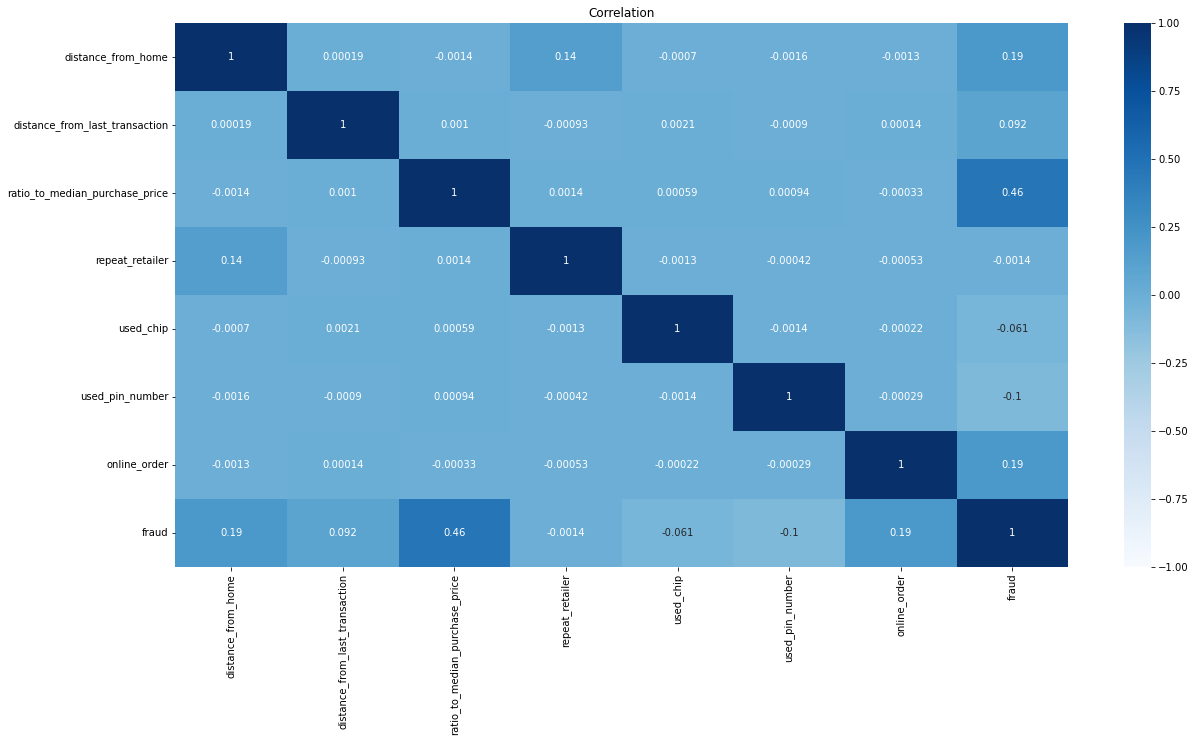

In [84]:
# Quais variáveis estão mais correlacionadas com a variável target?
plt.figure(figsize = (20,10))
plt.title('Correlation')
sns.heatmap(data.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
           );
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/Correlation1.png", dpi = 600 )

# Balanceamento da variável target

In [85]:
data['fraud'].value_counts(normalize = True)

0.0    0.912597
1.0    0.087403
Name: fraud, dtype: float64

In [86]:
data.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

Verificamos que nesse conjunto apenas 8% dos dados são de cartões fraudados

Para resolver o problema do balanceamento vamos primeiramente criar dois datasets, um para os dados com frades e outro com dados sem fraude

In [87]:
no_fraud=data[data.fraud == 0]
fraud=data[data.fraud == 1]

Pegando uma amostra de 5000 para cada cada dataset, com fraude e sem fraude

In [88]:
dt_no_fraude_sample=no_fraud.sample(n=5000)
dt_fraude_sample=fraud.sample(n=5000)

Criação de um novo dataset com as amostras criadas anteriormente

In [89]:
data_fraud=pd.concat([dt_no_fraude_sample,dt_fraude_sample],axis=0)

In [90]:
data_fraud['fraud'].value_counts(normalize = True)

0.0    0.5
1.0    0.5
Name: fraud, dtype: float64

In [91]:
data_fraud.shape

(10000, 8)

In [92]:
data_fraud.corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,-0.024576,-0.083413,0.167413,-0.116635,-0.044198,0.071896,0.237706
distance_from_last_transaction,-0.024576,1.000000,-0.049518,-0.025021,-0.042441,-0.016363,0.032907,0.108936
ratio_to_median_purchase_price,-0.083413,-0.049518,1.000000,-0.045415,0.036273,-0.089465,0.140013,0.494471
repeat_retailer,0.167413,-0.025021,-0.045415,1.000000,0.016530,-0.001075,0.086025,-0.000630
used_chip,-0.116635,-0.042441,0.036273,0.016530,1.000000,0.024309,-0.024452,-0.124718
used_pin_number,-0.044198,-0.016363,-0.089465,-0.001075,0.024309,1.000000,-0.079621,-0.230433
online_order,0.071896,0.032907,0.140013,0.086025,-0.024452,-0.079621,1.000000,0.404107
fraud,0.237706,0.108936,0.494471,-0.000630,-0.124718,-0.230433,0.404107,1.000000


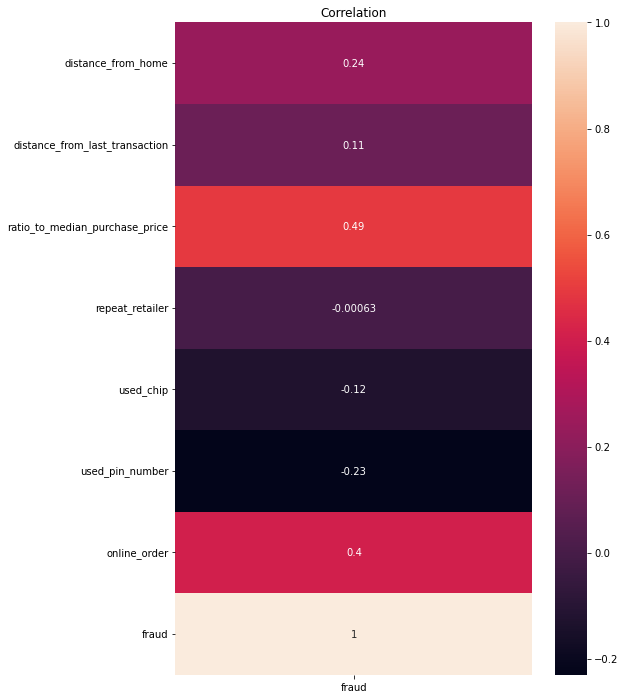

In [93]:
plt.figure(figsize = (8,12))
plt.title('Correlation')
sns.heatmap(data_fraud.corr()[['fraud']], 
            annot = True
           );
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/Correlation2.png", dpi = 600 )

Observando a distribuição dos dados

In [94]:
#sns.pairplot(data_fraud, 
#            hue = 'fraud'
#             );

# Criação de uma lista vazia para armazenar as métricas dos modelos

In [95]:
data_all=[]

# Definição das matriz features, variável varget

Definindo a matriz de features e a variável target

In [96]:
X = data_fraud.drop(columns=['fraud'],axis=1)
y = data_fraud["fraud"]

# Split do dataset de treino e de teste

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=12)

Padronização das features do modelos de treino e de teste

In [98]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Modelo 1: Regressão Logística

Instanciando um objeto da classe LogisticRegression

In [99]:
lr = LogisticRegression()

Ajuste do modelo

In [100]:
lr.fit(X_train_std, y_train)

LogisticRegression()

Visualização dos coeficientes

In [101]:
print(lr.coef_)
print(lr.intercept_)

[[ 2.79764052  1.89942964  5.44194441 -0.43396925 -0.60586954 -2.34735524
   2.12915359]]
[0.22712885]


Previsão da acurácia com o modelo treinado

In [102]:
score_train_lr = accuracy_score(y_train, lr.predict(X_train_std))
print('Score train: ', score_train_lr)

Score train:  0.9461333333333334


Matriz de confusão do modelo de treino

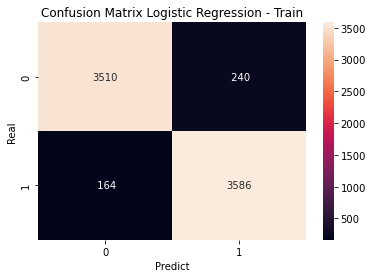

In [103]:
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Logistic Regression - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-LR-Train.png", dpi = 600 )

Observamos que há uma acurácia de 94%, dos 3750 casos positivos de fraud 3588 foram fraudes verdadeiras. Isso implica que nosso classificador está dizendo 95% das detecções de fraudes são positivas.

Previsão da acurácia com o modelo de teste

In [104]:
y_test_pred_lr = lr.predict(X_test_std)

Acurácia do modelo de teste

In [105]:
score_test_lr = accuracy_score(y_test, y_test_pred_lr)
print('Score test: ', score_test_lr)

Score test:  0.9424


Matriz de confusão do modelo de teste

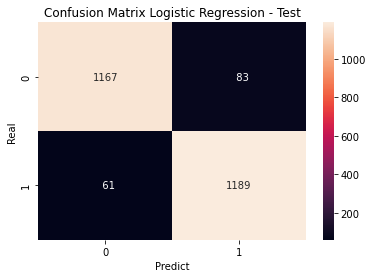

In [106]:
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Logistic Regression - Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-LR-test.png", dpi = 600 )

Observamos que há uma acurácia de 94%, dos 1250 casos positivos de fraud 1188 foram fraudes verdadeiras. Isso implica que nosso classificador está dizendo 95% das detecções de fraudes são positivas.

Métricas do modelo de teste

In [107]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_lr, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       0.95      0.93      0.94      1250
     Fraud 1       0.93      0.95      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



Inserindo as métricas na lista para armazenamento

In [108]:
m='Logistic Regression'
test_recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_test_pred_lr, pos_label=1)
test_auc_lr = auc(fpr_lr,tpr_lr)
f1_score_lr = f1_score(y_test, y_test_pred_lr)
data_all.append([m,score_train_lr,score_test_lr,test_recall_lr,test_auc_lr,f1_score_lr])

# Modelo 2: Randon Forest

Instanciando a classe Randon Forest

In [109]:
rf=RandomForestClassifier()

Treino do modelo usando os conjuntos de treinamento y_pred=clf.predict(X_test)

In [110]:
rf.fit(X_train_std, y_train)

RandomForestClassifier()

Previsão da acurácia com o modelo de teste

In [111]:
score_train_rf = accuracy_score(y_train, rf.predict(X_train_std))
print('Score train: ', score_train_rf)

Score train:  1.0


Atribuindo A variável y_test_pred a previsão

In [112]:
y_test_pred_rf = rf.predict(X_test_std)

Atribuindo a variável score_test a acurácia

In [113]:
score_test_rf = accuracy_score(y_test, y_test_pred_rf)
print('Score test: ', score_test_rf)

Score test:  0.9984


Matriz de confusão do modelo de treino

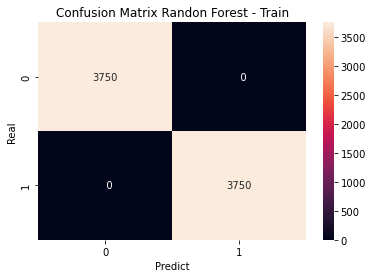

In [114]:
sns.heatmap(confusion_matrix(y_train, rf.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Randon Forest - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-RF-train.png", dpi = 600 )

Matriz de confusão do modelo de teste

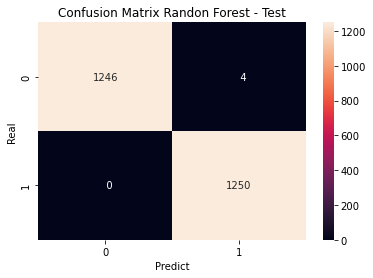

In [115]:
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Randon Forest - Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-RF-test.png", dpi = 600 )

Observando as métricas

In [116]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_rf, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      1.00      1.00      1250
     Fraud 1       1.00      1.00      1.00      1250

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



Inserindo as métricas na lista para armazenamento

In [117]:
m='Randon Forest'
test_recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_pred_rf, pos_label=1)
test_auc_rf = auc(fpr_rf,tpr_rf)
f1_score_rf = f1_score(y_test, y_test_pred_rf)
data_all.append([m,score_train_rf,score_test_rf,test_recall_rf,test_auc_rf,f1_score_rf])

# Modelo 3: KNeighborsRegressor

Escolha da escolher metrica (Euclidean,  Manhattan ou Chebyshev)
Escolher com quantos vizinhos a quantidade de vizinhos próximos pelo modelo de validação cruzada.

In [118]:
# Usamos cross validation co, 5 folds
kf = KFold(n_splits = 5, shuffle = True, random_state = 12)
scores_para_df = []
for i in range(1, 26):
# Em cada iteração, instanciamos o modelo com um hiperparâmetro diferente
    model_euclidean = KNeighborsClassifier(metric = 'euclidean', n_neighbors = i)
    model_manhattan = KNeighborsClassifier(metric = 'manhattan', n_neighbors = i)
    model_chebyshev = KNeighborsClassifier(metric = 'chebyshev', n_neighbors = i)
# cross_val_scores retorna uma matriz de 5 resultados,
# um para cada partição que automaticamente criou CV
    cv_scores = cross_val_score(model_euclidean, X_train_std, y_train, cv = kf)
    cv_scores2 = cross_val_score(model_manhattan, X_train_std, y_train, cv = kf)
    cv_scores3 = cross_val_score(model_chebyshev, X_train_std, y_train, cv = kf)
# Para cada valor de n_neighbours, criamos um dicionário com o valor
# de n_neighbours e a média das pontuações
    dict_row_score = { 'n_neighbors': i, 'euclidean': np.mean(cv_scores),'manhattan': np.mean(cv_scores2),'chebyshev': np.mean(cv_scores3)}

# Salvamos cada um na lista definida fora do loop
    scores_para_df.append(dict_row_score)

De acordo com os vizinhos próximos as 3 melhores accuracy das metricas estão grifadas em amarelo

In [119]:
df_scores = pd.DataFrame(scores_para_df)

In [120]:
df_scores.style.highlight_max(subset=['euclidean','manhattan','chebyshev'])

,n_neighbors,euclidean,manhattan,chebyshev
0,1,0.990800,0.991067,0.991067
1,2,0.987467,0.988267,0.986267
2,3,0.988400,0.989333,0.987467
3,4,0.988933,0.988533,0.988933
4,5,0.988533,0.988000,0.987467
5,6,0.987733,0.986800,0.988400
6,7,0.987200,0.986933,0.986667
7,8,0.987467,0.987067,0.987067
8,9,0.986267,0.986533,0.985467
9,10,0.986667,0.986933,0.985733


Conforme identificado acima qual melhor parâmetro de distância e vizinhos se aplica ao modelo.

In [121]:
knn = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 3)

Treino do modelo usando a distancia e métrica identificada

In [122]:
knn.fit(X_train_std, y_train);

Previsão com o modelo de teste

In [123]:
y_test_pred_knn = knn.predict(X_test_std)

Previsão valores e a acurácia

In [124]:
accuracy_score(y_test, y_test_pred_knn).round(4)

0.9904

In [125]:
score_train_knn = accuracy_score(y_train, knn.predict(X_train_std))
print('Score train: ', score_train_knn)

Score train:  0.9961333333333333


In [126]:
score_test_knn = accuracy_score(y_test, y_test_pred_knn)
print('Score test: ', score_test_knn)

Score test:  0.9904


Matriz de confusão modelo treino

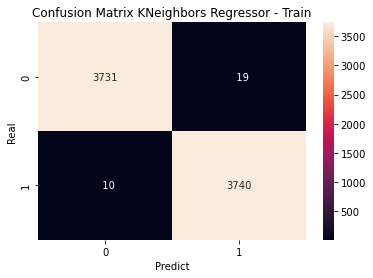

In [127]:
sns.heatmap(confusion_matrix(y_train, knn.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix KNeighbors Regressor - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-knn-train.png", dpi = 600 )

Matriz de confusão modelo teste

In [128]:
confusion_matrix(y_test,y_test_pred_knn)

array([[1228,   22],
       [   2, 1248]], dtype=int64)

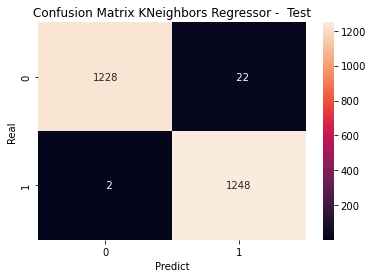

In [129]:
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix KNeighbors Regressor -  Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-knn-test.png", dpi = 600 )

Observando as métricas

In [130]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_knn, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      0.98      0.99      1250
     Fraud 1       0.98      1.00      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



Inserindo as métricas na lista para armazenamento

In [131]:
m='KNN'
test_recall_knn = recall_score(y_test, y_test_pred_knn, pos_label=1)
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_test_pred_knn, pos_label=1)
test_auc_knn = auc(fpr_knn,tpr_knn)
f1_score_knn = f1_score(y_test, y_test_pred_knn)
data_all.append([m,score_train_knn,score_test_knn,test_recall_knn,test_auc_knn,f1_score_knn])

# Modelo 4: Decision Tree Classifier

Intanciando a classe Decison Tree Classifier, definimos o random_state de 12

In [132]:
dt = DecisionTreeClassifier(random_state=12)

Treino do modelo 

In [133]:
dt.fit(X_train_std, y_train)

DecisionTreeClassifier(random_state=12)

Previsão valores e a acurácia

In [134]:
y_test_pred_dt = dt.predict(X_test_std)

Previsão acurácia de treino

In [135]:
score_train_dt = accuracy_score(y_train, dt.predict(X_train_std))
print('Score train: ', score_train_dt)

Score train:  1.0


Previsão acurácia de teste

In [136]:
score_test_dt = accuracy_score(y_test, y_test_pred_dt)
print('Score test: ', score_test_dt)

Score test:  0.9988


Imprimindo a media aboluta

In [137]:
mean_abs_dt = mean_absolute_error(y_test, y_test_pred_dt)
print('Mean Absolute Error: ', mean_abs_dt)

Mean Absolute Error:  0.0012


Criando a matriz de confusão modelo treino

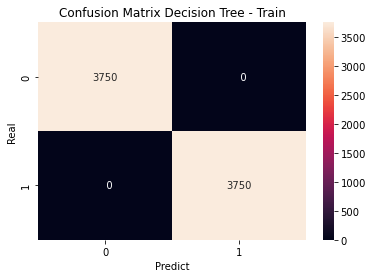

In [138]:
sns.heatmap(confusion_matrix(y_train, dt.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Decision Tree - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-DT-train.png", dpi = 600 )

Criando a matriz de confusão modelo teste

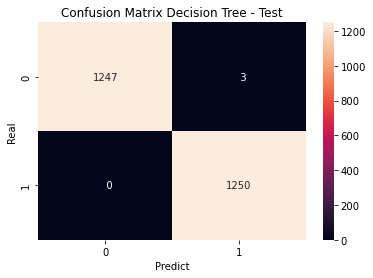

In [139]:
sns.heatmap(confusion_matrix(y_test, dt.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Decision Tree - Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/confusion-DT-test.png", dpi = 600 )

In [140]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_dt, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      1.00      1.00      1250
     Fraud 1       1.00      1.00      1.00      1250

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



Inserindo as métricas na lista para armazenamento

In [141]:
m='DT'
test_recall_dt = recall_score(y_test, y_test_pred_dt, pos_label=1)
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_test_pred_dt, pos_label=1)
test_auc_dt = auc(fpr_dt,tpr_dt)
f1_score_dt = f1_score(y_test, y_test_pred_dt)
data_all.append([m,score_train_dt,score_test_dt,test_recall_dt,test_auc_dt,f1_score_dt])

### Calculando as probabilidades para a previsão 

In [142]:
r_probs = [0 for _ in range (len(y_test))]
lr_probs = lr.predict_proba(X_test_std)
rf_probs = rf.predict_proba(X_test_std)
knn_probs = knn.predict_proba(X_test_std)
dt_probs = dt.predict_proba(X_test_std)

In [143]:
lr_probs = lr_probs[:,1]
rf_probs = rf_probs[:,1]
knn_probs = knn_probs[:,1]
dt_probs = dt_probs[:,1]

In [144]:
r_auc = roc_auc_score(y_test, r_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
dt_auc = roc_auc_score(y_test, dt_probs)

Imprimindo AUROC scores com os modelos Logistic Regression, Randon Forest e Decision Tree

In [145]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Logistic Regression: AUROC = %.3f' % (lr_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('KNeighbors Regressor: AUROC = %.3f' % (knn_auc))
print('Decision Tree: AUROC = %.3f' % (dt_auc))

Random (chance) Prediction: AUROC = 0.500
Logistic Regression: AUROC = 0.979
Random Forest: AUROC = 1.000
KNeighbors Regressor: AUROC = 0.995
Decision Tree: AUROC = 0.999


Calculando a Curva ROC dos modelos

In [146]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, rf_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

Plotando a curva ROC

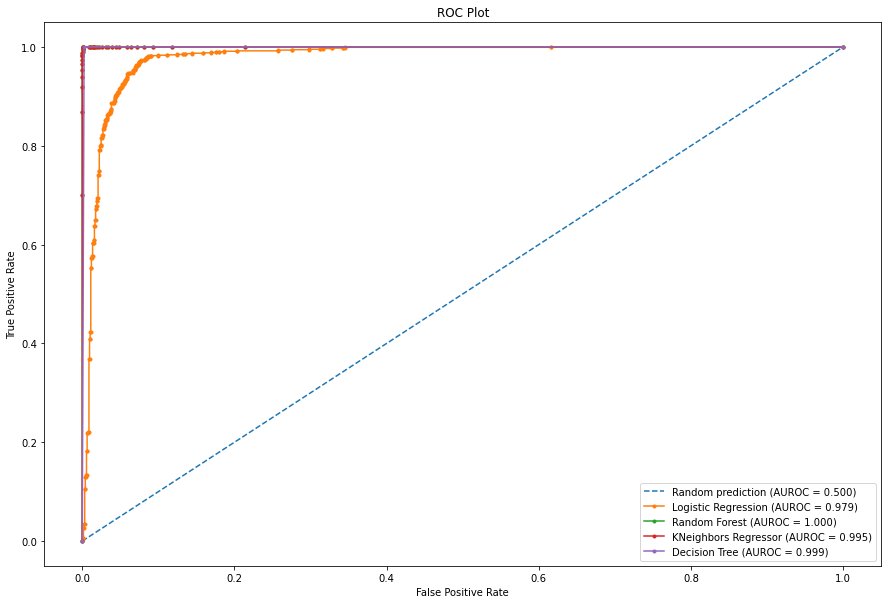

In [147]:
plt.figure(figsize = (15,10))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNeighbors Regressor (AUROC = %0.3f)' % knn_auc)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % dt_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/ROC-plot.png", dpi = 600 )
plt.show()

### Resumo das métricas dos modelos

Atribuindo nome das colunas no dataframe de métricas e imprimindo as informações de todos modelos.

In [148]:
models=['Logistic','Randon Forest', 'KNeighbors','Decision Tree']
pd_scores=pd.DataFrame(data_all,columns=['model','train score','test score','test recall','test_auc','F1 Score'])
print(pd_scores)

                 model  train score  test score  test recall  test_auc  \
0  Logistic Regression     0.946133      0.9424       0.9512    0.9424   
1        Randon Forest     1.000000      0.9984       1.0000    0.9984   
2                  KNN     0.996133      0.9904       0.9984    0.9904   
3                   DT     1.000000      0.9988       1.0000    0.9988   

   F1 Score  
0  0.942902  
1  0.998403  
2  0.990476  
3  0.998801  


## Diagramas de Confiabilidade

Vizualização de quão bem calibradas as probabilidades previstas estão usando curvas de calibração nos modelos de treino

In [149]:
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (rf, "RandomForest"),
    (knn, "KNeighbors"),
    (gnb, "Naive Bayes"),
    (dt, "DecisionTree"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]



C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


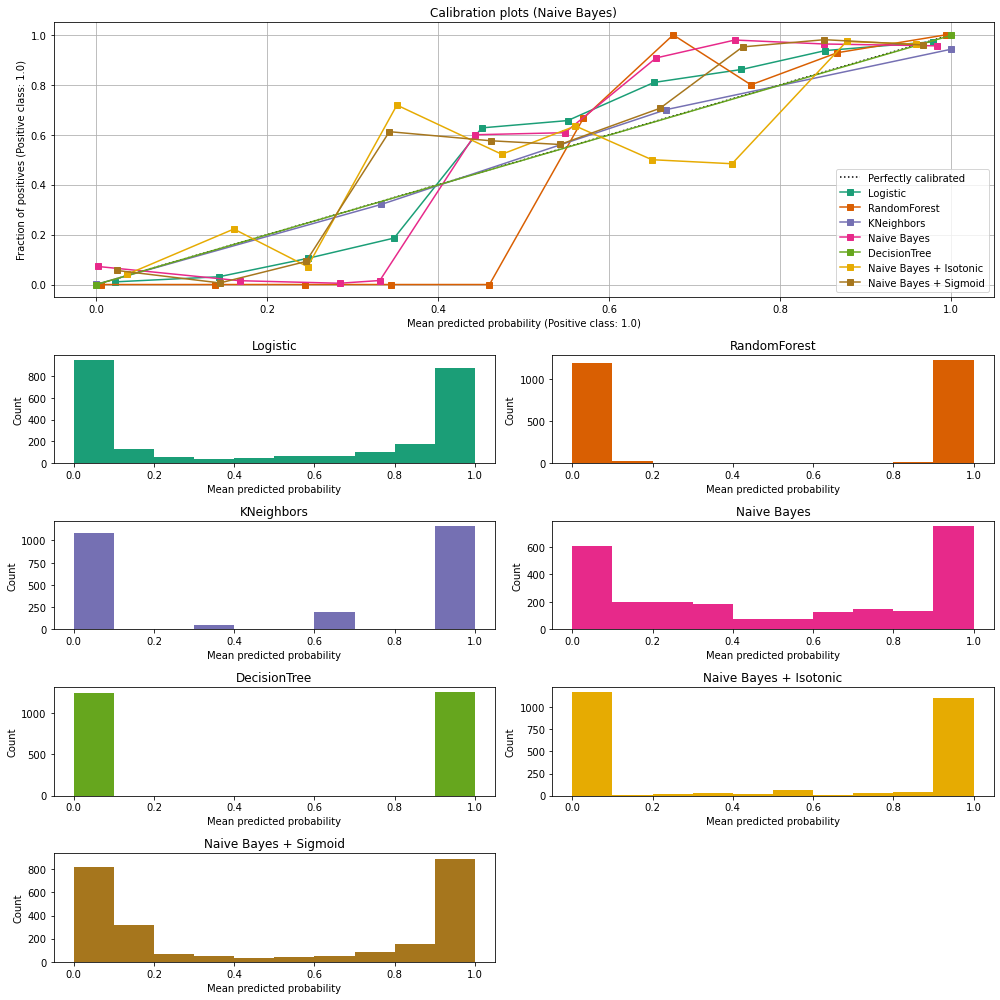

In [150]:
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.savefig("../Projeto-Integrador-III--Fraude-Cartao-Credito/img/CalibrationDisplay-plot.png", dpi = 600 )
plt.show()
